In [1]:
import gtda 
import sklearn
import persim
import ripser
import gudhi

import pandas as pd
import numpy as np
import kmapper as km
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns

from sklearn import ensemble
from sklearn.model_selection import train_test_split
from kmapper.plotlyviz import *
from sklearn.decomposition import PCA
from ipywidgets import (HBox, VBox)
from sklearn.tree import DecisionTreeClassifier 
from ripser import Rips
from persim import PersImage, PersistenceImager, persistent_entropy

In [3]:
df = pd.read_csv("input_data/audit_risk.csv")

In [4]:
df["Risk"].value_counts()

0    471
1    305
Name: Risk, dtype: int64

In [5]:
df.groupby("Risk",axis=0).mean()

Sector_score    PARA_A   Score_A    Risk_A     PARA_B   Score_B  \
Risk                                                                    
0        27.892611  0.720446  0.264544  0.285635   0.447667  0.226327   
1         8.281246  5.121379  0.485246  2.996276  26.786689  0.447213   

         Risk_B      TOTAL   numbers  Score_B.1  ...      PROB    RiSk_E  \
Risk                                             ...                       
0      0.160085   1.168113  5.002123   0.200849  ...  0.200849  0.422930   
1     15.868164  31.827412  5.168852   0.259016  ...  0.214426  0.667541   

       History      Prob    Risk_F     Score  Inherent_Risk  CONTROL_RISK  \
Risk                                                                        
0     0.002123  0.200425  0.000849  2.159660       1.964002      0.423779   
1     0.262295  0.241967  0.135082  3.540984      41.951181      0.802623   

      Detection_Risk  Audit_Risk  
Risk                              
0                0.5    0.416806  
1                0.5   17.594018  

[2 rows x 25 columns]

In [6]:
df = df[df["LOCATION_ID"]!='LOHARU']
df = df[df["LOCATION_ID"]!='NUH']
df = df[df["LOCATION_ID"]!='SAFIDON']

In [7]:
df["LOCATION_ID"] = df["LOCATION_ID"].astype(str).astype(int)

In [8]:
df.isna().sum()

Sector_score      0
LOCATION_ID       0
PARA_A            0
Score_A           0
Risk_A            0
PARA_B            0
Score_B           0
Risk_B            0
TOTAL             0
numbers           0
Score_B.1         0
Risk_C            0
Money_Value       1
Score_MV          0
Risk_D            0
District_Loss     0
PROB              0
RiSk_E            0
History           0
Prob              0
Risk_F            0
Score             0
Inherent_Risk     0
CONTROL_RISK      0
Detection_Risk    0
Audit_Risk        0
Risk              0
dtype: int64

In [9]:
df = df.dropna()

<AxesSubplot:xlabel='Risk', ylabel='count'>

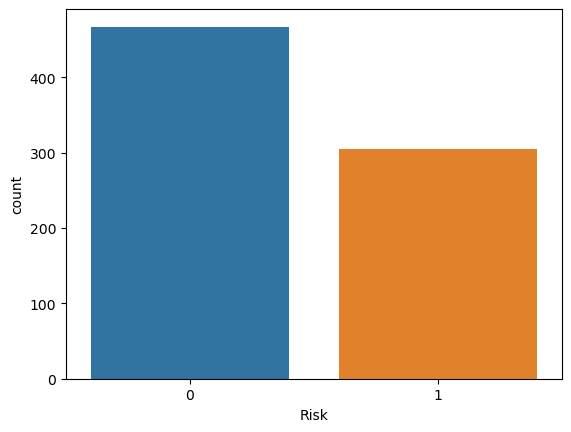

In [10]:
sns.countplot(x="Risk",data=df)

<AxesSubplot:>

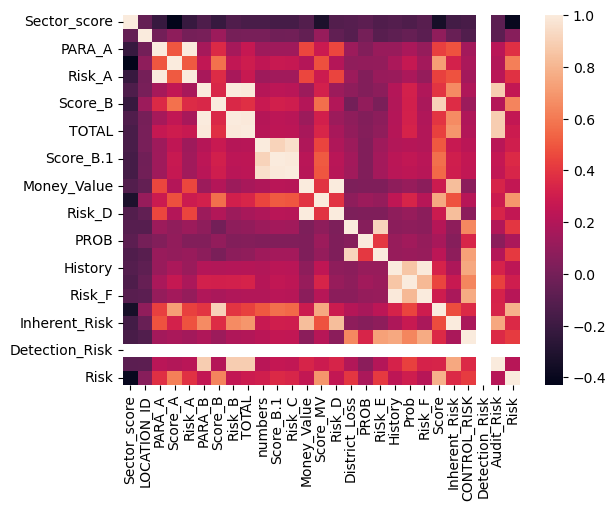

In [11]:
sns.heatmap(df.corr())

In [12]:
feature_names = [c for c in df.columns if c not in ["Risk"]]
X = np.array(df[feature_names])
y = np.array(df["Risk"])

In [13]:
test = df.to_numpy()
test1 = np.array([test])
test1.shape

(1, 772, 27)

In [14]:
model = sklearn.ensemble.IsolationForest(random_state=00)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

In [15]:
mapper = km.KeplerMapper(verbose=0)
lens2 = mapper.fit_transform(df, projection="Risk")

In [16]:
lens = np.c_[lens1]

In [17]:
scomplex = mapper.map(lens,
                      X,
                      cover=km.Cover(n_cubes=3,
                                     perc_overlap=0.3),
                      clusterer=sklearn.cluster.AgglomerativeClustering())

In [18]:
pl_brewer = [[0.0, '#006837'],
             [0.1, '#1a9850'],
             [0.2, '#66bd63'],
             [0.3, '#a6d96a'],
             [0.4, '#d9ef8b'],
             [0.5, '#ffffbf'],
             [0.6, '#fee08b'],
             [0.7, '#fdae61'],
             [0.8, '#f46d43'],
             [0.9, '#d73027'],
             [1.0, '#a50026']]

color_values = lens [:,0] - lens[:,0].min()
my_colorscale = pl_brewer
kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex,
                                                                 color_values,
                                                                 color_function_name='Distance to x-min',
                                                                 colorscale=my_colorscale)

for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]

bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale,
                                 factor_size=2.5, edge_linewidth=0.5)

layout = plot_layout(title='Topological network representing the<br>  Audit Risk',
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),
                     bgcolor=bgcolor)

In [19]:
fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)

fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph,
                             fw_graph,
                             ctooltips=True, # ctooltips = True, because we assigned a label to each
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor,
                             member_textbox_width=600)
fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'

In [20]:
VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [21]:
breastc_dict = {0: 'No Risk', 1: 'Risk'}
tooltips = list(fw_graph.data[1].text) # we perform this conversion because fw.data[1].text is a tuple and we want to update
                                     # the tooltips

new_color = []
for j, node in enumerate(kmgraph['nodes']):
    member_label_ids = y[scomplex['nodes'][node['name']]]
    member_labels = [breastc_dict[id] for id in member_label_ids]
    label_type, label_counts = np.unique(member_labels, return_counts=True)

    n_members = label_counts.sum()
    if label_type.shape[0] == 1:
        if label_type[0] == 'No Risk':
            new_color.append(0)
        else:
            new_color.append(1)
    else:
        new_color.append(1.0*label_counts[1]/n_members)#multiply by 1 for python 2.7.+

    for m in range(len(label_counts)):
        tooltips[j] += '<br>' + str(label_type[m]) + ': ' + str(label_counts[m]) + ': ' + str(label_counts[m]/n_members*100) # append  how many benign/malign
                                                                                 # members exist in each node

fwn_graph = go.FigureWidget(fw_graph) # copy the initial FigureWidget

with fwn_graph.batch_update(): # make updates for the new figure
    fwn_graph.data[1].text = tooltips # add the new tooltips
    fwn_graph.data[1].marker.colorbar.x = -0.14 # place toolbar at the figure left side
    fwn_graph.layout.width = 550 # change the figure size in order to plot two "parallel" copies
    fwn_graph.layout.height = 550
    fwn_graph.layout.margin.r = 45 # decrease the right margin from 60px (default val) to 45 pixels

fw1 = go.FigureWidget(fwn_graph) # define a new figure from  the fwn_graph that will be colored by the new color function
with fw1.batch_update():
    fw1.data[1].marker.color = new_color # update node colors
    fw1.data[0].line.color = 'rgb(125,125,125)' # update the graph edge color
    fw1.layout.plot_bgcolor = 'rgb(240,240,240)'
    fw1.layout.annotations = None # remove the mapper_summary from the second plot
    fw1.data[1].marker.showscale = False # remove the colorbar
    fw1.layout.title = "Nodes are colored according to the proportion<br> of Risky members"

In [22]:
HBox([fwn_graph, fw1])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [23]:
train_size, test_size = 540,232
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666
)

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

In [25]:
clf = DecisionTreeClassifier(max_depth=2,criterion='gini')
N = KNeighborsClassifier(n_neighbors=50)
fit = clf.fit(X_train,y_train)
fitn = N.fit(X_train,y_train)

In [26]:
predictedn = N.predict(X_test)

In [27]:
predicted = clf.predict(X_test)

In [28]:
print(classification_report(predictedn,y_test))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       170
           1       0.67      1.00      0.81        62

    accuracy                           0.87       232
   macro avg       0.84      0.91      0.85       232
weighted avg       0.91      0.87      0.88       232



In [29]:
dftrain = pd.DataFrame(X_train)
dftrain["Risk"] = y_train


In [30]:
dftest = pd.DataFrame(X_test)
dftest["Risk"] = y_test


In [31]:
from gtda.mapper import CubicalCover
import gtda.mapper
from gtda.mapper import make_mapper_pipeline
from gtda.mapper import plot_static_mapper_graph
from sklearn.preprocessing import MinMaxScaler


In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
k = pca.fit_transform(X)
t = pd.DataFrame(pca.components_,columns=feature_names,index = ['PC-1','PC-2'])
#print(t)
for columns in t:
    print(t[columns])

PC-1   -0.041193
PC-2   -0.002210
Name: Sector_score, dtype: float64
PC-1   -0.004311
PC-2    0.006512
Name: LOCATION_ID, dtype: float64
PC-1    0.023553
PC-2   -0.015971
Name: PARA_A, dtype: float64
PC-1    0.000525
PC-2    0.000069
Name: Score_A, dtype: float64
PC-1    0.014328
PC-2   -0.009544
Name: Risk_A, dtype: float64
PC-1    0.365592
PC-2    0.435570
Name: PARA_B, dtype: float64
PC-1    0.000593
PC-2    0.000208
Name: Score_B, dtype: float64
PC-1    0.219512
PC-2    0.261501
Name: Risk_B, dtype: float64
PC-1    0.388085
PC-2    0.421185
Name: TOTAL, dtype: float64
PC-1    0.000680
PC-2    0.000041
Name: numbers, dtype: float64
PC-1    0.000236
PC-2    0.000002
Name: Score_B.1, dtype: float64
PC-1    0.001532
PC-2   -0.000003
Name: Risk_C, dtype: float64
PC-1    0.469599
PC-2   -0.608541
Name: Money_Value, dtype: float64
PC-1    0.000715
PC-2   -0.000160
Name: Score_MV, dtype: float64
PC-1    0.281879
PC-2   -0.365551
Name: Risk_D, dtype: float64
PC-1    0.001119
PC-2    0.00091

In [33]:
from gtda.mapper import make_mapper_pipeline
from gtda.mapper import plot_static_mapper_graph
from gtda.mapper import plot_interactive_mapper_graph
from sklearn.preprocessing import MinMaxScaler

In [34]:
df1 = df.copy()
dft = df1
df1 = np.array(df1)

In [35]:
dftest.columns[26]

'Risk'

In [36]:
Control_Riskscaler = MinMaxScaler()
node_size = 30
filter_func = gtda.mapper.filter.Projection([dftest.columns[26]])
#5,7,8,12,14,22
clusterer = sklearn.cluster.AgglomerativeClustering()
cover = gtda.mapper.cover.OneDimensionalCover(kind = 'balanced',n_intervals=3, overlap_frac=.3)

mapper = make_mapper_pipeline(

                              filter_func=filter_func,
                              cover = cover,
                            
                              clusterer=clusterer) 

plotly_params = {"node_trace": {}}
plot_static_mapper_graph(mapper, dftest, color_data=dftest, node_scale=node_size,
                          plotly_params=plotly_params)

C:\Users\91789\miniconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\91789\miniconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': '#888', 'width': 1},
       …

In [37]:
Control_Riskscaler = MinMaxScaler()
node_size = 30
filter_func = gtda.mapper.filter.Projection([dftest.columns[26]])
#5,7,8,12,14,22
clusterer = sklearn.cluster.AgglomerativeClustering()
cover = gtda.mapper.cover.OneDimensionalCover(kind = 'balanced',n_intervals=3, overlap_frac=.7)

mapper = make_mapper_pipeline(

                              filter_func=filter_func,
                              cover = cover,
                            
                              clusterer=clusterer) 

plotly_params = {"node_trace": {}}
plot_static_mapper_graph(mapper, df, color_data=df, node_scale=node_size,
                          plotly_params=plotly_params)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': '#888', 'width': 1},
       …

In [38]:
ogdf = mapper.fit_transform(df)

In [39]:
ht = [df.iloc[ogdf.vs[2]["node_elements"]],df.iloc[ogdf.vs[5]["node_elements"]]]
rt = df.iloc[ogdf.vs[1]["node_elements"]]
mix = df.iloc[ogdf.vs[0]["node_elements"]]

In [42]:
mix.shape

(767, 27)

In [43]:
df.shape

(772, 27)

In [51]:
mix.shape

(767, 27)

In [50]:
df.shape

(772, 27)

In [59]:
merged = df.drop_duplicates().merge(mix.drop_duplicates(), how = "inner", 
         left_on=['Sector_score', 'LOCATION_ID', 'PARA_A', 'Score_A', 'Risk_A', 'PARA_B',
       'Score_B', 'Risk_B', 'TOTAL', 'numbers', 'Score_B.1', 'Risk_C',
       'Money_Value', 'Score_MV', 'Risk_D', 'District_Loss', 'PROB', 'RiSk_E',
       'History', 'Prob', 'Risk_F', 'Score', 'Inherent_Risk', 'CONTROL_RISK',
       'Detection_Risk', 'Audit_Risk', 'Risk'], 
         right_on=['Sector_score', 'LOCATION_ID', 'PARA_A', 'Score_A', 'Risk_A', 'PARA_B',
       'Score_B', 'Risk_B', 'TOTAL', 'numbers', 'Score_B.1', 'Risk_C',
       'Money_Value', 'Score_MV', 'Risk_D', 'District_Loss', 'PROB', 'RiSk_E',
       'History', 'Prob', 'Risk_F', 'Score', 'Inherent_Risk', 'CONTROL_RISK',
       'Detection_Risk', 'Audit_Risk', 'Risk'])

In [60]:
merged

Sector_score  LOCATION_ID  PARA_A  Score_A  Risk_A  PARA_B  Score_B  \
0            3.89           23    4.18      0.6   2.508    2.50      0.2   
1            3.89            6    0.00      0.2   0.000    4.83      0.2   
2            3.89            6    0.51      0.2   0.102    0.23      0.2   
3            3.89            6    0.00      0.2   0.000   10.80      0.6   
4            3.89            6    0.00      0.2   0.000    0.08      0.2   
..            ...          ...     ...      ...     ...     ...      ...   
749         55.57           18    0.75      0.2   0.150    0.45      0.2   
750         55.57           16    0.47      0.2   0.094    0.37      0.2   
751         55.57           14    0.24      0.2   0.048    0.04      0.2   
752         55.57           18    0.20      0.2   0.040    0.00      0.2   
753         55.57           15    0.00      0.2   0.000    0.00      0.2   

     Risk_B  TOTAL  numbers  ...  RiSk_E  History  Prob  Risk_F  Score  \
0     0.500   6.68      5.0  ...     0.4        0   0.2     0.0    2.4   
1     0.966   4.83      5.0  ...     0.4        0   0.2     0.0    2.0   
2     0.046   0.74      5.0  ...     0.4        0   0.2     0.0    2.0   
3     6.480  10.80      6.0  ...     0.4        0   0.2     0.0    4.4   
4     0.016   0.08      5.0  ...     0.4        0   0.2     0.0    2.0   
..      ...    ...      ...  ...     ...      ...   ...     ...    ...   
749   0.090   1.20      5.0  ...     0.4        0   0.2     0.0    2.0   
750   0.074   0.84      5.0  ...     0.4        0   0.2     0.0    2.0   
751   0.008   0.28      5.0  ...     0.4        0   0.2     0.0    2.0   
752   0.000   0.20      5.0  ...     0.4        0   0.2     0.0    2.0   
753   0.000   0.00      5.0  ...     0.4        0   0.2     0.0    2.0   

     Inherent_Risk  CONTROL_RISK  Detection_Risk  Audit_Risk  Risk  
0            8.574           0.4             0.5      1.7148     1  
1            2.554           0.4             0.5      0.5108     0  
2            1.548           0.4             0.5      0.3096     0  
3           17.530           0.4             0.5      3.5060     1  
4            1.416           0.4             0.5      0.2832     0  
..             ...           ...             ...         ...   ...  
749          1.640           0.4             0.5      0.3280     0  
750          1.568           0.4             0.5      0.3136     0  
751          1.456           0.4             0.5      0.2912     0  
752          1.440           0.4             0.5      0.2880     0  
753          1.464           0.4             0.5      0.2928     0  

[754 rows x 27 columns]

In [56]:
mix.columns

Index(['Sector_score', 'LOCATION_ID', 'PARA_A', 'Score_A', 'Risk_A', 'PARA_B',
       'Score_B', 'Risk_B', 'TOTAL', 'numbers', 'Score_B.1', 'Risk_C',
       'Money_Value', 'Score_MV', 'Risk_D', 'District_Loss', 'PROB', 'RiSk_E',
       'History', 'Prob', 'Risk_F', 'Score', 'Inherent_Risk', 'CONTROL_RISK',
       'Detection_Risk', 'Audit_Risk', 'Risk'],
      dtype='object')

In [67]:
output = pd.read_csv('output.csv')
#output.drop(columns = "Untitled: 0")

In [68]:
output['Point']

0       5.0
1      10.0
2      20.0
3      28.0
4      29.0
5      32.0
6      51.0
7      59.0
8      61.0
9      68.0
10     76.0
11     93.0
12    104.0
13    115.0
14    116.0
15    118.0
16    123.0
17    127.0
18    128.0
19    131.0
20    153.0
21    162.0
22    171.0
23    175.0
24    196.0
25    200.0
26    202.0
27    206.0
28    211.0
Name: Point, dtype: float64

In [75]:
test = pd.DataFrame(X_test)

In [78]:
df.columns

Index(['Sector_score', 'LOCATION_ID', 'PARA_A', 'Score_A', 'Risk_A', 'PARA_B',
       'Score_B', 'Risk_B', 'TOTAL', 'numbers', 'Score_B.1', 'Risk_C',
       'Money_Value', 'Score_MV', 'Risk_D', 'District_Loss', 'PROB', 'RiSk_E',
       'History', 'Prob', 'Risk_F', 'Score', 'Inherent_Risk', 'CONTROL_RISK',
       'Detection_Risk', 'Audit_Risk', 'Risk'],
      dtype='object')

In [79]:
a = test[test.index.isin(output['Point'])]

In [82]:
a.shape

(29, 26)

In [85]:
a.columns = ['Sector_score', 'LOCATION_ID', 'PARA_A', 'Score_A', 'Risk_A', 'PARA_B',
       'Score_B', 'Risk_B', 'TOTAL', 'numbers', 'Score_B.1', 'Risk_C',
       'Money_Value', 'Score_MV', 'Risk_D', 'District_Loss', 'PROB', 'RiSk_E',
       'History', 'Prob', 'Risk_F', 'Score', 'Inherent_Risk', 'CONTROL_RISK',
       'Detection_Risk', 'Audit_Risk']

In [93]:
mix = mix[['Sector_score', 'LOCATION_ID', 'PARA_A', 'Score_A', 'Risk_A', 'PARA_B',
       'Score_B', 'Risk_B', 'TOTAL', 'numbers', 'Score_B.1', 'Risk_C',
       'Money_Value', 'Score_MV', 'Risk_D', 'District_Loss', 'PROB', 'RiSk_E',
       'History', 'Prob', 'Risk_F', 'Score', 'Inherent_Risk', 'CONTROL_RISK',
       'Detection_Risk', 'Audit_Risk']]

In [90]:
a.shape

(29, 26)

In [94]:
mix.merge(a, how = "inner")

Sector_score  LOCATION_ID  PARA_A  Score_A  Risk_A  PARA_B  Score_B  \
0           3.89            3    0.94      0.2   0.188    0.01      0.2   
1           3.89            5    0.00      0.2   0.000    0.94      0.2   
2           3.89            2    0.00      0.2   0.000    0.00      0.2   
3           3.89            2    0.74      0.2   0.148    1.00      0.2   
4           3.89           15    0.00      0.2   0.000    1.88      0.2   
5           3.89           13    0.00      0.2   0.000    0.87      0.2   
6           3.41           39    1.07      0.4   0.428    0.00      0.2   
7           3.41           32    0.77      0.2   0.154    0.00      0.2   
8           3.41           22    0.65      0.2   0.130    0.00      0.2   
9           3.41           11    1.21      0.4   0.484    0.00      0.2   
10          2.72           16    1.34      0.4   0.536    0.00      0.2   
11          2.72           12    1.05      0.4   0.420    0.00      0.2   
12          2.37            6    1.46      0.4   0.584    0.55      0.2   
13          2.37           28    0.32      0.2   0.064    0.49      0.2   
14          1.99           25    0.53      0.2   0.106    0.00      0.2   
15          1.99           14    1.26      0.4   0.504    0.00      0.2   
16          1.99           30    0.66      0.2   0.132    0.00      0.2   
17          1.99           27    0.60      0.2   0.120    0.00      0.2   
18          1.99           16    1.53      0.4   0.612    0.00      0.2   
19          1.85            6    0.47      0.2   0.094    1.59      0.4   
20          1.85            4    2.96      0.6   1.776    0.15      0.2   
21          1.85           13    4.99      0.6   2.994    0.64      0.2   
22          1.85            8    0.99      0.2   0.198    0.00      0.2   
23          1.85           11    1.69      0.4   0.676    0.21      0.2   
24         21.61           32    0.61      0.2   0.122    0.63      0.2   
25         21.61           22    0.37      0.2   0.074    0.46      0.2   
26         21.61           16    0.27      0.2   0.054    0.35      0.2   
27         55.57            8    1.05      0.4   0.420    2.17      0.6   
28         55.57            2    1.06      0.4   0.424    0.63      0.2   

    Risk_B  TOTAL  numbers  ...  PROB  RiSk_E  History  Prob  Risk_F  Score  \
0    0.002   0.95      5.0  ...   0.2     0.4        0   0.2     0.0    2.0   
1    0.188   0.94      5.0  ...   0.2     0.4        0   0.2     0.0    2.0   
2    0.000   0.00      5.0  ...   0.2     0.4        0   0.2     0.0    2.0   
3    0.200   1.74      5.0  ...   0.2     0.4        0   0.2     0.0    2.0   
4    0.376   1.88      5.0  ...   0.2     0.4        0   0.2     0.0    2.0   
5    0.174   0.87      5.0  ...   0.2     0.4        0   0.2     0.0    2.0   
6    0.000   1.07      5.0  ...   0.2     0.4        0   0.2     0.0    2.6   
7    0.000   0.77      5.0  ...   0.2     0.4        0   0.2     0.0    2.0   
8    0.000   0.65      5.0  ...   0.2     0.4        0   0.2     0.0    2.0   
9    0.000   1.21      5.0  ...   0.2     0.4        0   0.2     0.0    2.2   
10   0.000   1.34      5.0  ...   0.2     0.8        0   0.2     0.0    2.4   
11   0.000   1.05      5.0  ...   0.2     0.4        0   0.2     0.0    2.2   
12   0.110   2.01      5.0  ...   0.2     0.4        0   0.2     0.0    2.2   
13   0.098   0.81      5.0  ...   0.2     1.2        0   0.2     0.0    2.6   
14   0.000   0.53      5.0  ...   0.2     0.4        0   0.2     0.0    2.0   
15   0.000   1.26      5.0  ...   0.2     0.4        0   0.2     0.0    2.2   
16   0.000   0.66      5.0  ...   0.2     0.4        0   0.2     0.0    2.0   
17   0.000   0.60      5.0  ...   0.2     0.4        0   0.2     0.0    2.0   
18   0.000   1.53      5.0  ...   0.2     0.8        0   0.2     0.0    2.4   
19   0.636   2.06      5.0  ...   0.2     0.4        0   0.2     0.0    2.6   
20   0.030   3.11      5.0  ...   0.2     0.4        0   0.2     0.0    2.4   
21   0.128   5.

In [42]:
testdf = pd.DataFrame(X_test)
testdf['Risk'] = y_test
testdf.head()

0     1     2    3      4      5    6       7      8    9  ...   17  \
0   2.72  16.0  2.84  0.6  1.704  64.91  0.6  38.946  67.75  5.5  ...  0.8   
1   2.72   4.0  0.00  0.2  0.000   0.00  0.2   0.000   0.00  5.0  ...  0.4   
2   2.37   8.0  0.56  0.2  0.112   0.08  0.2   0.016   0.64  5.0  ...  1.2   
3  55.57   9.0  0.51  0.2  0.102   1.63  0.4   0.652   2.14  5.0  ...  0.4   
4  55.57   8.0  0.80  0.2  0.160   0.57  0.2   0.114   1.37  5.0  ...  0.4   

    18   19   20   21       22   23   24       25  Risk  
0  0.0  0.2  0.0  4.6  118.404  0.8  0.5  47.3616     1  
1  0.0  0.2  0.0  2.0    1.400  0.4  0.5   0.2800     0  
2  0.0  0.2  0.0  2.4    2.338  1.2  0.5   1.4028     1  
3  0.0  0.2  0.0  2.6    2.514  0.4  0.5   0.5028     0  
4  0.0  0.2  0.0  2.0    1.674  0.4  0.5   0.3348     0  

[5 rows x 27 columns]

In [25]:
graphtest = mapper.fit_transform(dftest)

/home/jayati/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/jayati/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [26]:
ht = [dftest.iloc[graphtest.vs[1]["node_elements"]],dftest.iloc[graphtest.vs[3]["node_elements"]]]
rt = [dftest.iloc[graphtest.vs[2]["node_elements"]],dftest.iloc[graphtest.vs[0]["node_elements"]]]

In [27]:
rips = Rips(maxdim=2)
dgmht1 = rips.fit_transform(ht[0])
dgmht2 = rips.fit_transform(ht[1])
dgmrt1 = rips.fit_transform(rt[0])
dgmrt2 = rips.fit_transform(rt[1])


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [36]:
dftest1 = pd.DataFrame(X_test)


In [46]:
resData = mix.merge(testdf, how = 'inner' ,indicator=True)
resData.shape

(92980, 54)

In [29]:
dftest1.iloc[0]


0       2.7200
1      16.0000
2       2.8400
3       0.6000
4       1.7040
5      64.9100
6       0.6000
7      38.9460
8      67.7500
9       5.5000
10      0.4000
11      2.2000
12    124.5900
13      0.6000
14     74.7540
15      4.0000
16      0.2000
17      0.8000
18      0.0000
19      0.2000
20      0.0000
21      4.6000
22    118.4040
23      0.8000
24      0.5000
25     47.3616
Name: 0, dtype: float64

In [30]:
dftest1.shape

(232, 26)

In [31]:
y_test

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0])

In [34]:
rips = Rips(maxdim=2,verbose=False)
dgmht1 = rips.fit_transform(ht[0])
dgmht2 = rips.fit_transform(ht[1])
dgmrt1 = rips.fit_transform(rt[0])
dgmrt2 = rips.fit_transform(rt[1])
mystr = ''
dist = []
listtar = []
for j in range(232):
    t1 = dftest1.iloc[j]
    hy1 = ht[0].append(t1)
    hy1 = hy1.fillna(0)
    hy2 = ht[1].append(t1)
    hy2 = hy2.fillna(0)
    ry1 = rt[0].append(t1)
    ry1 = ry1.fillna(1)
    ry2 = rt[1].append(t1)
    ry2 = ry2.fillna(1)
    myloc = [f'dgmhy1 and dgmht{j}',f'dgmhy2 and dgmht{j}',f'dgmry1 and dgmrt{j}',f'dgmry2 and dgmrt{j}']
    dgmhy1 = rips.fit_transform(hy1)
    dgmhy2 = rips.fit_transform(hy2)
    dgmry1 = rips.fit_transform(ry1)
    dgmry2 = rips.fit_transform(ry2)
    
    for i in range(2):
        distances = np.array([persim.wasserstein(dgmhy1[i],dgmht1[i]),persim.wasserstein(dgmhy2[i],dgmht2[i]),persim.wasserstein(dgmry1[i],dgmrt1[i]),persim.wasserstein(dgmry2[i],dgmrt2[i])])
        dist.append(distances)
#print(dist)
        #nz = distances.nonzero()
        
        #try:
        #    mindist = min(distances[nz])
        #except:
        #    print(f'Everything is 0 in homology {i}')
        #    continue
        #mystr = mystr+f'for t = {j} minimun distance for homology {i} is {mindist} at location {np.where(distances == mindist)[0]}\n'
        #loctar = np.where(distances == mindist)[0]
        #if (loctar == 0 ):
        #    target = 0
        #elif (loctar == 1 ):
        #    target = 0
        #else:
        #    target = 1
    #print(f' for t = {j}, {loctar} is loc and target is {target}')
    #listar = np.append(listar, target)
   
            
#print(mystr)   
             

/tmp/ipykernel_464923/2575970184.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_464923/2575970184.py:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_464923/2575970184.py:15: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_464923/2575970184.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:51: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:61: UserWarning:

dgm2 has points with non-finite death times;ignoring th

In [37]:
len(dist)

464

In [39]:
y_test.shape

(232,)

In [42]:
pd.DataFrame(y_test)

0
0    1
1    0
2    1
3    0
4    0
..  ..
227  0
228  0
229  0
230  1
231  0

[232 rows x 1 columns]

In [43]:
l = []
for i in range(len(y_test)):
    l = l+[i,i]


In [49]:
actual = []
for i in y_test:
    actual = actual+[i,i]
    
actual


[1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,


In [35]:
distancesdf = pd.DataFrame(dist)
distancesdf.to_csv('alldistances.csv')

In [45]:
distancesdf['Point']=l

In [50]:
distancesdf['Actual']=actual

In [ ]:
distancesdf.to_csv('alldistances.csv')

In [41]:
distancesdf.shape

(464, 4)

In [116]:
y_test[0:20]

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0])

In [88]:
t1 = dftest1.iloc[3]
hy1 = ht[0].append(t1)
hy1 = hy1.fillna(0)
hy2 = ht[1].append(t1)
hy2 = hy2.fillna(0)
ry1 = rt[0].append(t1)
ry1 = ry1.fillna(1)
ry2 = rt[1].append(t1)
ry2 = ry2.fillna(1)
myloc = [f'dgmhy1 and dgmht{j}',f'dgmhy2 and dgmht{j}',f'dgmry1 and dgmrt{j}',f'dgmry2 and dgmrt{j}']
dgmhy1 = rips.fit_transform(hy1)
dgmhy2 = rips.fit_transform(hy2)
dgmry1 = rips.fit_transform(ry1)
dgmry2 = rips.fit_transform(ry2)

/tmp/ipykernel_27787/3695859111.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_27787/3695859111.py:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_27787/3695859111.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/tmp/ipykernel_27787/3695859111.py:8: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [86]:
rips = Rips(maxdim=2)
dgmhy1 = rips.fit_transform(hy1)
dgmhy2 = rips.fit_transform(hy2)
dgmry1 = rips.fit_transform(ry1)
dgmry2 = rips.fit_transform(ry2)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [98]:
persim.wasserstein(dgmht2[1],dgmhy2[1])


0.0

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:51: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:61: UserWarning:

dgm2 has points with non-finite death times;ignoring those points



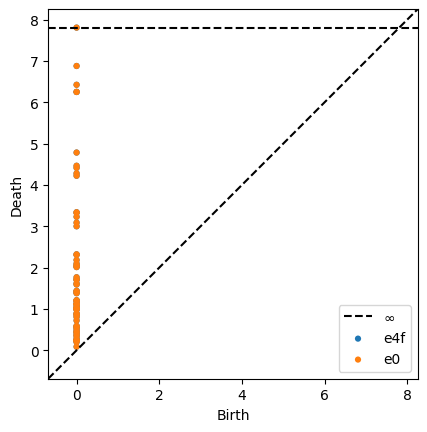

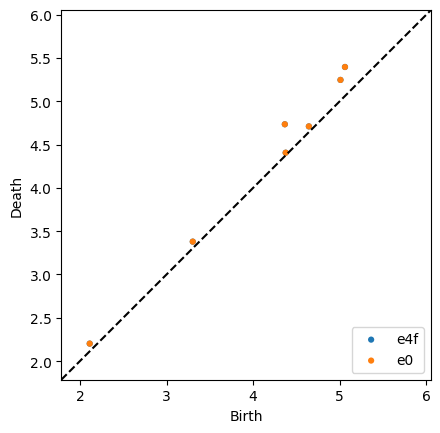

/home/jayati/.local/lib/python3.10/site-packages/persim/visuals.py:155: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.

/home/jayati/.local/lib/python3.10/site-packages/persim/visuals.py:156: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.



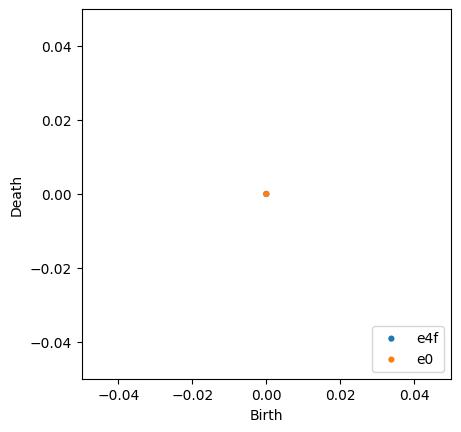

In [95]:
for i in range(3):
    dist_bottleneck, matching = persim.wasserstein(dgmht2[i],dgmhy2[i],matching=True)
    persim.wasserstein_matching(dgmht2[i],dgmhy2[i],matching, labels=['e4f','e0'])
    plt.show()

In [ ]:
from gudhi.wasserstein.barycenter import lagrangian_barycenter
import numpy as np

2022-11-16 22:57:43.996529: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 22:57:43.996592: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:51: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:61: UserWarning:

dgm2 has points with non-finite death times;ignoring those points



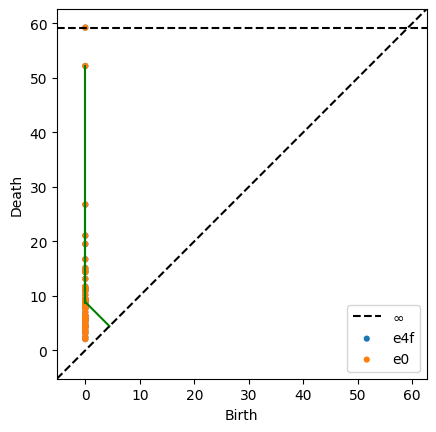

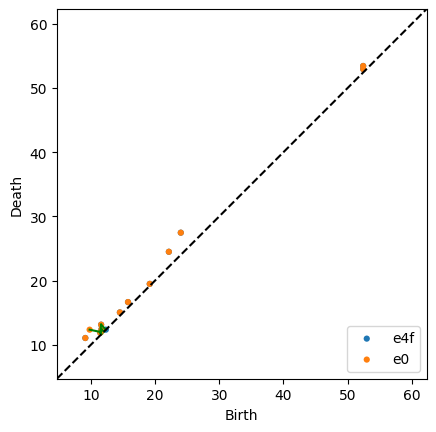

/home/jayati/.local/lib/python3.10/site-packages/persim/visuals.py:155: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.

/home/jayati/.local/lib/python3.10/site-packages/persim/visuals.py:156: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.



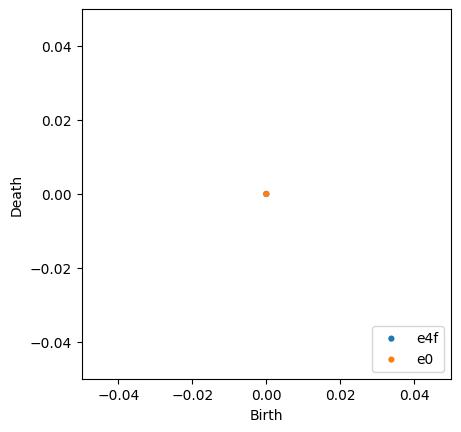

In [75]:
for i in range(3):
    dist_bottleneck, matching = persim.wasserstein(dgmry1[i],dgmrt1[i],matching=True)
    persim.wasserstein_matching(dgmrt1[i],dgmry1[i],matching, labels=['e4f','e0'])
    plt.show()

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:51: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:61: UserWarning:

dgm2 has points with non-finite death times;ignoring those points



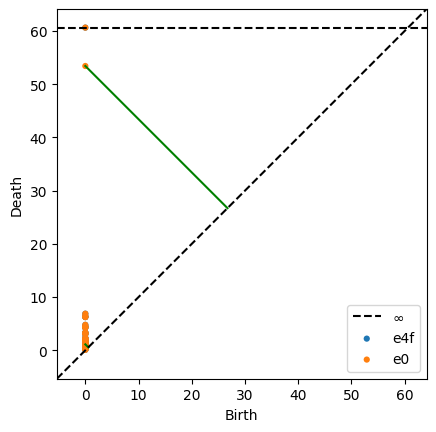

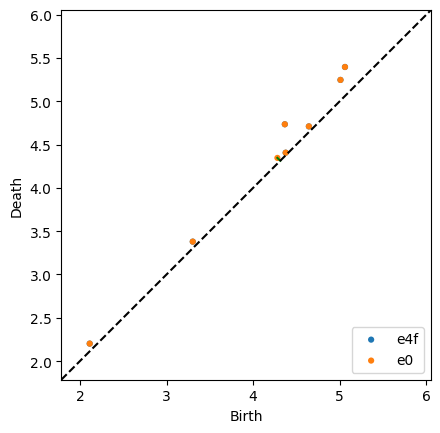

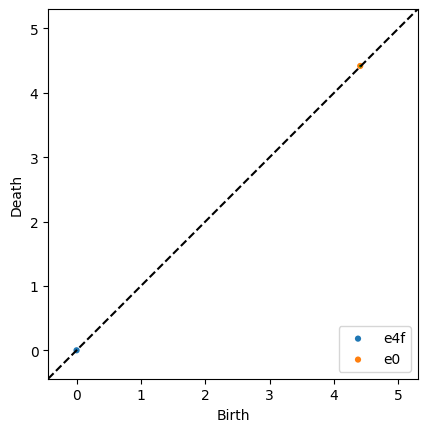

In [76]:
for i in range(3):
    dist_bottleneck, matching = persim.wasserstein(dgmht2[i],dgmhy2[i],matching=True)
    persim.wasserstein_matching(dgmht2[i],dgmhy2[i],matching, labels=['e4f','e0'])
    plt.show()

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:51: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:61: UserWarning:

dgm2 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/visuals.py:155: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.

/home/jayati/.local/lib/python3.10/site-packages/persim/visuals.py:156: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.



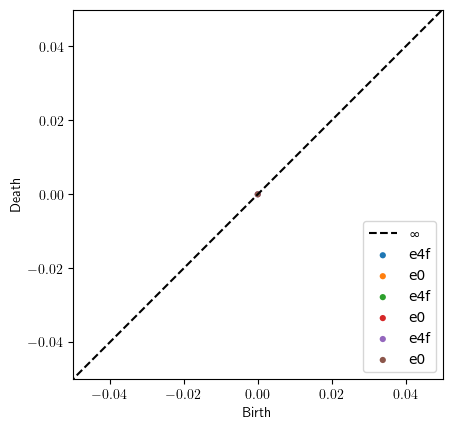

In [ ]:
for i in range(3):
    dist_bottleneck, matching = persim.wasserstein(dgmrt1[i],dgmry1[i],matching=True)
    persim.wasserstein_matching(dgmrt1[i],dgmry1[i],matching, labels=['e4f','e0'])
plt.show()

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:51: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:61: UserWarning:

dgm2 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/visuals.py:155: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.

/home/jayati/.local/lib/python3.10/site-packages/persim/visuals.py:156: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.



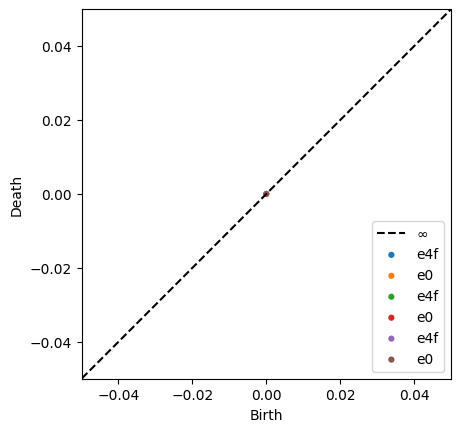

In [ ]:
for i in range(3):
    dist_bottleneck, matching = persim.wasserstein(dgmrt2[i],dgmry2[i],matching=True)
    persim.wasserstein_matching(dgmrt2[i],dgmry2[i],matching, labels=['e4f','e0'])
plt.show()

In [ ]:
for i in range(2):
    print(f'bottleneck distance between ht1 and hy1 in {i}th homology is {persim.bottleneck(dgmhy1[i],dgmht1[i])}')
    print(f'bottleneck distance between ht2 and hy2 in {i}th homology is {persim.bottleneck(dgmhy2[i],dgmht2[i])}')
    print(f'bottleneck distance between rt1 and ry1 in {i}th homology is {persim.bottleneck(dgmry1[i],dgmrt1[i])}')
    print(f'bottleneck distance between rt2 and ry2 in {i}th homology is {persim.bottleneck(dgmry2[i],dgmrt2[i])}')

/home/jayati/.local/lib/python3.10/site-packages/persim/bottleneck.py:56: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/bottleneck.py:66: UserWarning:

dgm2 has points with non-finite death times;ignoring those points



bottleneck distance between ht1 and hy1 in 0th homology is 0.1875607669353485
bottleneck distance between ht2 and hy2 in 0th homology is 26.43054962158203
bottleneck distance between rt1 and ry1 in 0th homology is 1.0258972644805908
bottleneck distance between rt2 and ry2 in 0th homology is 6.849503993988037
bottleneck distance between ht1 and hy1 in 1th homology is 0.008453726768493652
bottleneck distance between ht2 and hy2 in 1th homology is 0.0
bottleneck distance between rt1 and ry1 in 1th homology is 0.0
bottleneck distance between rt2 and ry2 in 1th homology is 0.0


In [ ]:
for i in range(2):
    print(f'wasserstein distance between ht1 and hy1 in {i}th homology is {persim.wasserstein(dgmhy1[i],dgmht1[i])}')
    print(f'wasserstein distance between ht2 and hy2 in {i}th homology is {persim.wasserstein(dgmhy2[i],dgmht2[i])}')
    print(f'wasserstein distance between rt1 and ry1 in {i}th homology is {persim.wasserstein(dgmry1[i],dgmrt1[i])}')
    print(f'wasserstein distance between rt2 and ry2 in {i}th homology is {persim.wasserstein(dgmry2[i],dgmrt2[i])}')

wasserstein distance between ht1 and hy1 in 0th homology is 0.26870057347914017
wasserstein distance between ht2 and hy2 in 0th homology is 37.37844173581639
wasserstein distance between rt1 and ry1 in 0th homology is 3.855219350677588
wasserstein distance between rt2 and ry2 in 0th homology is 39.815805449144186
wasserstein distance between ht1 and hy1 in 1th homology is 0.011955375048600352
wasserstein distance between ht2 and hy2 in 1th homology is 0.0
wasserstein distance between rt1 and ry1 in 1th homology is 0.0
wasserstein distance between rt2 and ry2 in 1th homology is 0.0


/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:51: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:61: UserWarning:

dgm2 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:51: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:61: UserWarning:

dgm2 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:51: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:61: UserWarning:

dgm2 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserst

In [ ]:
for i in range(2):
    print(f'sliced wasserstein distance between ht1 and hy1 in {i}th homology is {persim.sliced_wasserstein(dgmhy1[i],dgmht1[i])}')
    print(f'sliced wasserstein distance between ht2 and hy2 in {i}th homology is {persim.sliced_wasserstein(dgmhy2[i],dgmht2[i])}')
    print(f'sliced wasserstein distance between rt1 and ry1 in {i}th homology is {persim.sliced_wasserstein(dgmry1[i],dgmrt1[i])}')
    print(f'sliced wasserstein distance between rt2 and ry2 in {i}th homology is {persim.sliced_wasserstein(dgmry2[i],dgmrt2[i])}')

sliced wasserstein distance between ht1 and hy1 in 0th homology is nan
sliced wasserstein distance between ht2 and hy2 in 0th homology is nan
sliced wasserstein distance between rt1 and ry1 in 0th homology is nan
sliced wasserstein distance between rt2 and ry2 in 0th homology is nan
sliced wasserstein distance between ht1 and hy1 in 1th homology is 0.00761228025474452
sliced wasserstein distance between ht2 and hy2 in 1th homology is 0.0
sliced wasserstein distance between rt1 and ry1 in 1th homology is 0.0
sliced wasserstein distance between rt2 and ry2 in 1th homology is 0.0


/home/jayati/.local/lib/python3.10/site-packages/scipy/spatial/distance.py:1018: RuntimeWarning:

invalid value encountered in subtract



6.849503993988037

In [ ]:
import gudhi
from gudhi.persistence_graphical_tools import plot_persistence_barcode

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

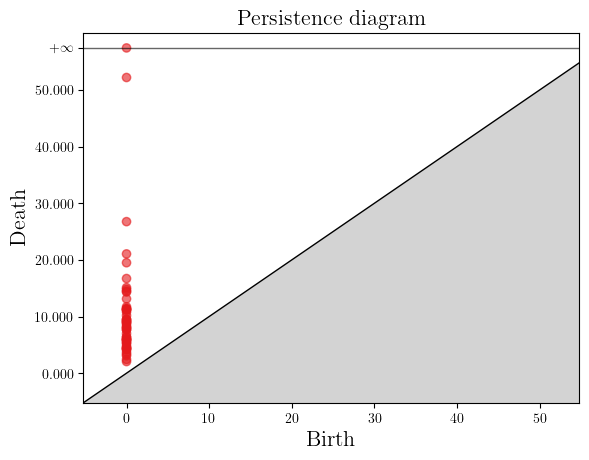

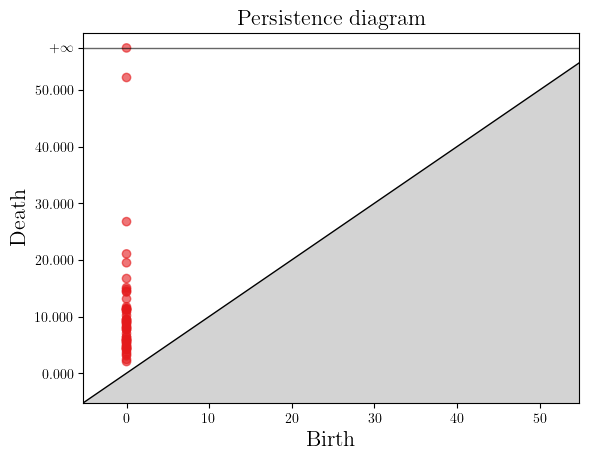

In [ ]:
gudhi.plot_persistence_diagram(dgmrt1[0])
gudhi.plot_persistence_diagram(dgmry1[0])

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

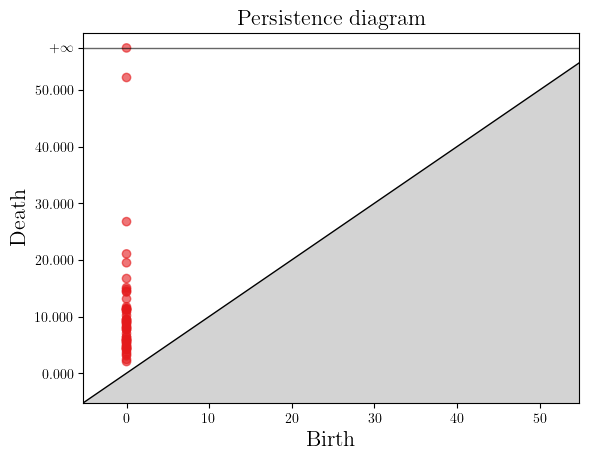

In [ ]:
gudhi.plot_persistence_diagram(dgmry1[0])

In [ ]:
from gudhi import wasserstein

In [ ]:
gudhi.wasserstein.wasserstein_distance(dgmht1[1],dgmhy1[1])

NameError: name 'ot' is not defined

In [ ]:
y_test[1]

0

In [ ]:
graph = mapper.fit_transform(df1)

In [ ]:
healthy1 = graph.vs[1]["node_elements"]
healthy2 = graph.vs[3]["node_elements"]
risk1 = graph.vs[0]["node_elements"]
risk2 = graph.vs[2]["node_elements"]

In [ ]:
rips = Rips(maxdim=2)
dgmht1 = rips.fit_transform(ht1)
rips.plot(dgmht1)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


IndexError: tuple index out of range

In [ ]:
h1 = df.iloc[healthy1]
h2 = df.iloc[healthy2]
r1 = df.iloc[risk1]
r2 = df.iloc[risk2]

In [ ]:
h1.describe().T.to_csv('h1.csv')

In [ ]:
h2.describe().T.to_csv('h2.csv')

In [ ]:
r1.describe().T.to_csv('r1.csv')

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


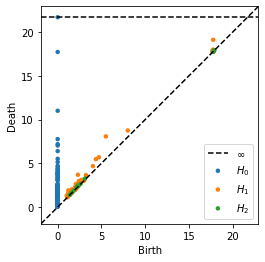

In [ ]:
rips = Rips(maxdim=2)
dgmh1 = rips.fit_transform(h1)
rips.plot(dgmh1)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


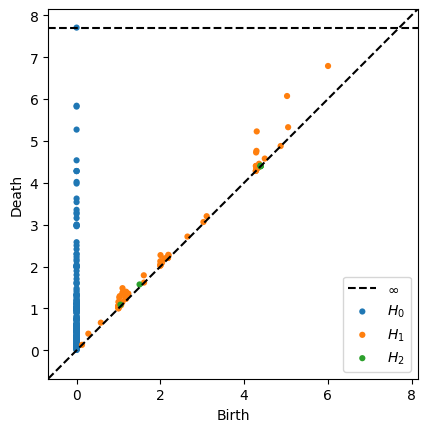

In [ ]:
rips = Rips(maxdim=2)
dgmh2 = rips.fit_transform(h2)
rips.plot(dgmh2)

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


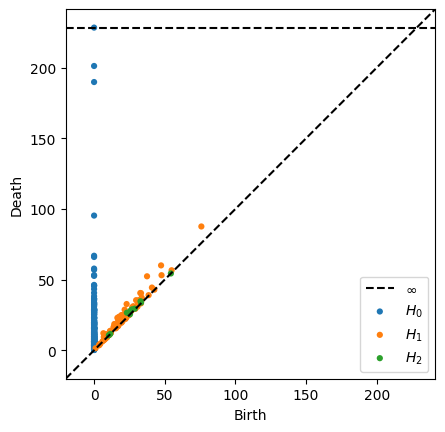

In [ ]:
rips = Rips(maxdim=2)
dgmr1 = rips.fit_transform(r1)
rips.plot(dgmr1)

<AxesSubplot:title={'center':'Persistence barcode'}>

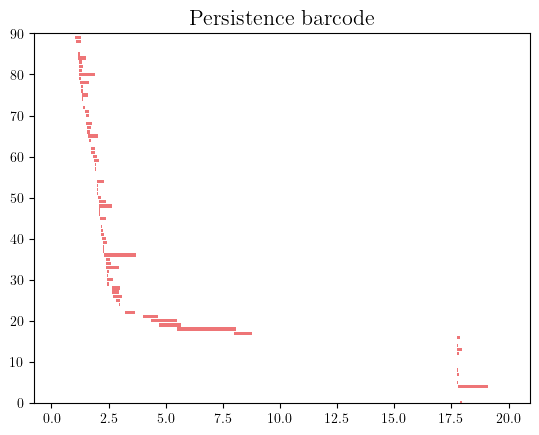

In [ ]:
gudhi.plot_persistence_barcode(dgmh1[1])

/home/jayati/.local/lib/python3.10/site-packages/persim/bottleneck.py:56: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/bottleneck.py:66: UserWarning:

dgm2 has points with non-finite death times;ignoring those points



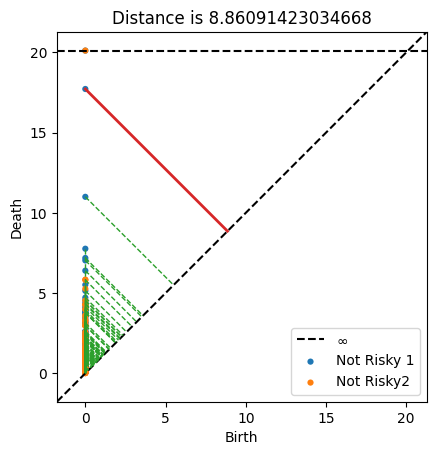

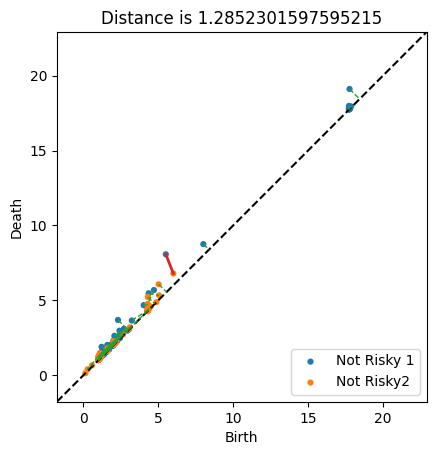

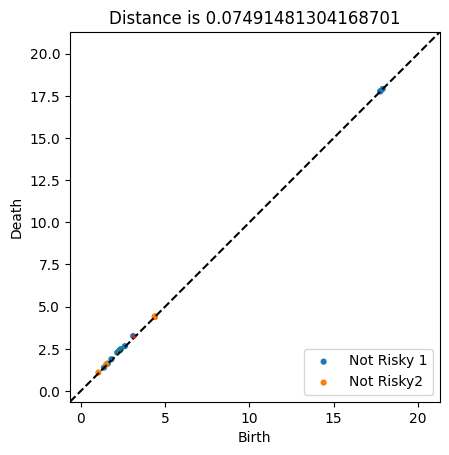

In [ ]:
for i in range(3):
    dist_bottleneck, matching = persim.bottleneck(dgmh1[i],dgmh2[i],matching=True)
    persim.bottleneck_matching(dgmh1[i],dgmh2[i],matching, labels=['Not Risky 1','Not Risky2'])
    plt.title(f'Distance is {dist_bottleneck}')
    plt.show()

/home/jayati/.local/lib/python3.10/site-packages/persim/bottleneck.py:56: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/bottleneck.py:66: UserWarning:

dgm2 has points with non-finite death times;ignoring those points



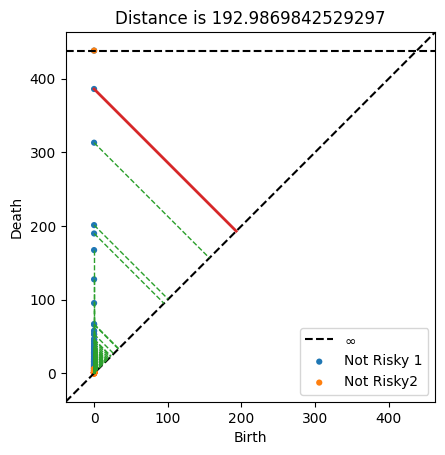

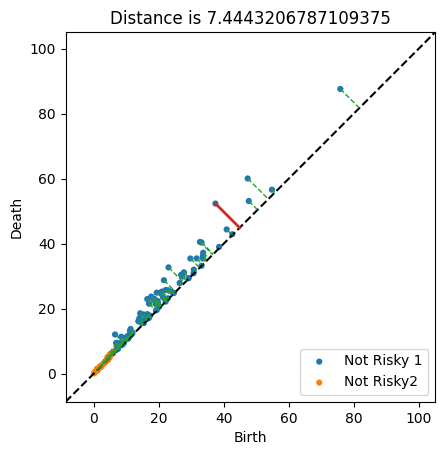

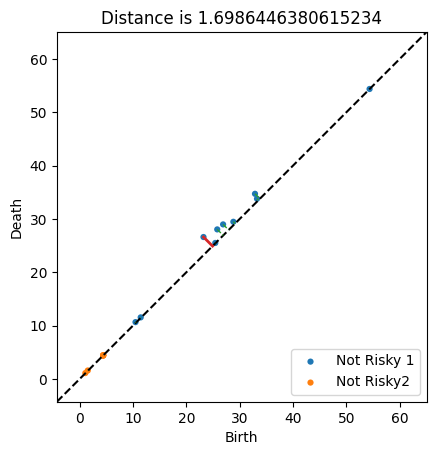

In [ ]:
for i in range(3):
    dist_bottleneck, matching = persim.bottleneck(dgmr1[i],dgmh2[i],matching=True)
    persim.bottleneck_matching(dgmr1[i],dgmh2[i],matching, labels=['Not Risky 1','Not Risky2'])
    plt.title(f'Distance is {dist_bottleneck}')
    plt.show()

/home/jayati/.local/lib/python3.10/site-packages/persim/bottleneck.py:56: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/bottleneck.py:66: UserWarning:

dgm2 has points with non-finite death times;ignoring those points



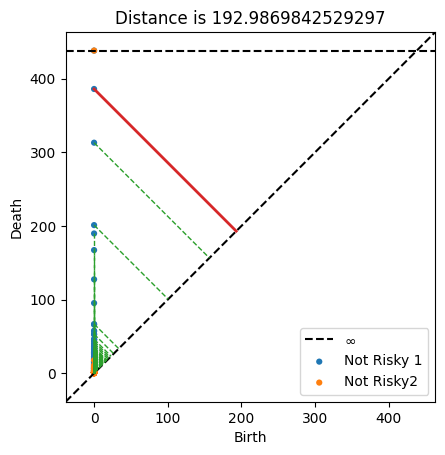

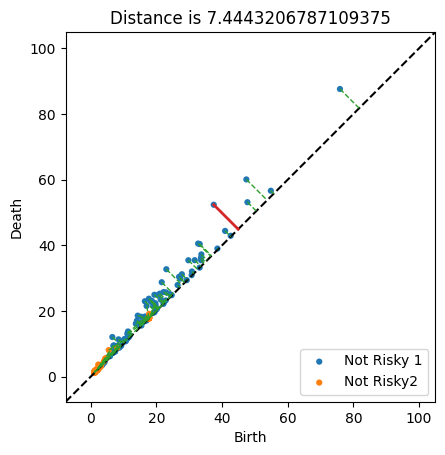

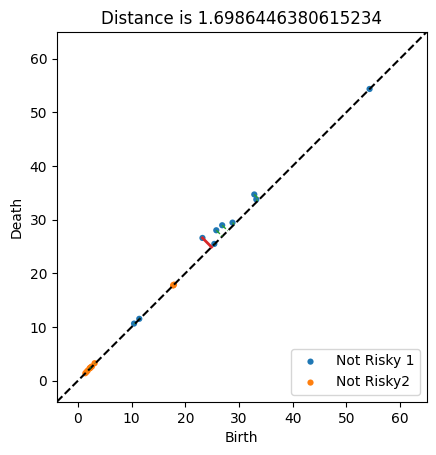

In [ ]:
for i in range(3):
    dist_bottleneck, matching = persim.bottleneck(dgmr1[i],dgmh1[i],matching=True)
    persim.bottleneck_matching(dgmr1[i],dgmh1[i],matching, labels=['Not Risky 1','Not Risky2'])
    plt.title(f'Distance is {dist_bottleneck}')
    plt.show()

In [ ]:
graph = mapper.fit_transform(df1)

In [ ]:
df["Risk"].value_counts()

0    467
1    305
Name: Risk, dtype: int64

In [ ]:
h1 = graph.vs[1]["node_elements"]
h2 = graph.vs[3]["node_elements"]
r1 = graph.vs[0]["node_elements"]

In [ ]:
set1 =set(h1)
set2 = set(h2)
set3 = set(r1)
setall = set1.union(set2)
setall = setall.union(set3)
newdata = list(setall)
dfnew = df.iloc[newdata]
dfnewl = np.array(dfnew)


In [ ]:
scaler = MinMaxScaler()
node_size = 20
filter_func = gtda.mapper.filter.Eccentricity()
#5,7,8,12,14,22
clusterer = gtda.mapper.FirstSimpleGap()
cover = gtda.mapper.cover.CubicalCover(kind = 'balanced',n_intervals=5, overlap_frac=.2)

mapper = make_mapper_pipeline(

                              filter_func=filter_func,
                              cover = cover,
                            
                              clusterer=clusterer) 

plotly_params = {"node_trace": {}}
plot_static_mapper_graph(mapper, dfh2, color_data = dfh2[dfh2.columns], node_scale=node_size,
                          plotly_params=plotly_params)

NameError: name 'dfh2' is not defined

In [ ]:
r1.shape

(304,)

In [ ]:
dfh1 = df.iloc[h1]
dfh2 = df.iloc[h2]
dfr1 = df.iloc[r1]

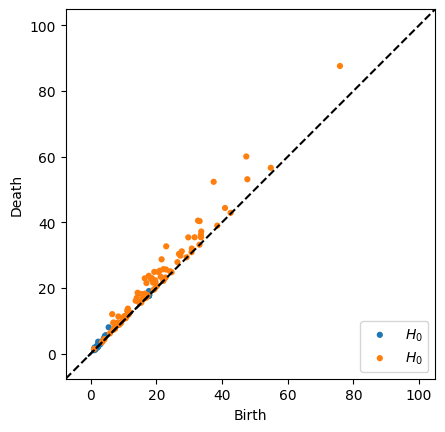

In [ ]:
#rips = Rips(maxdim=2)
dgm = rips.fit_transform(dfh1)
rips.plot(dgm[1])
#dgmh2 = rips.fit_transform(dfh2)
#rips.plot(dgmh2[1])
dgmr1 = rips.fit_transform(dfr1)
rips.plot(dgmr1[1])
plt.show()


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


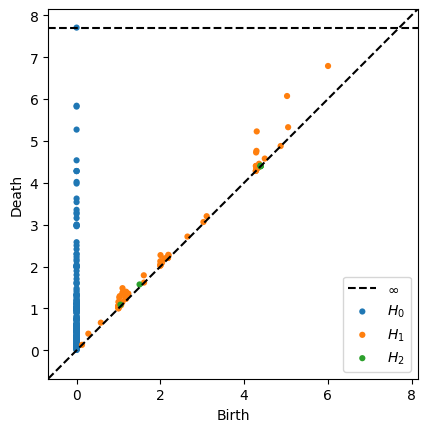

In [ ]:
rips = Rips(maxdim=2)
dgmh2 = rips.fit_transform(dfh2)
rips.plot(dgmh2)
plt.show()


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


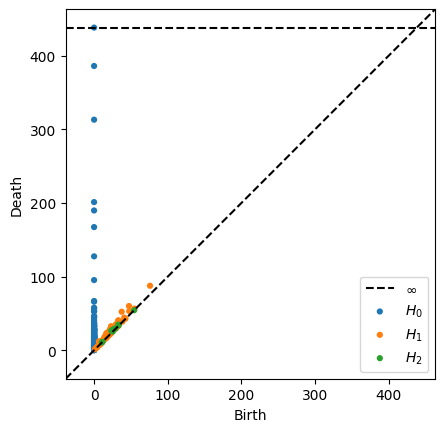

In [ ]:
rips = Rips(maxdim=2)
dgmr1 = rips.fit_transform(dfr1)
rips.plot(dgmr1)
plt.show()

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:51: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:61: UserWarning:

dgm2 has points with non-finite death times;ignoring those points



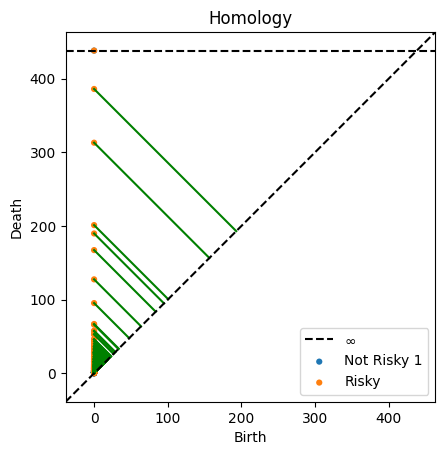

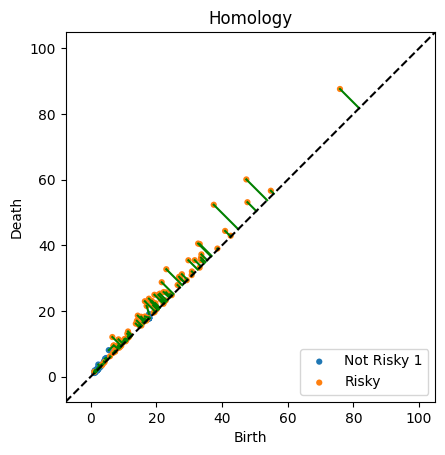

In [ ]:
for i in range(2):
    dist_bottleneck, matching = persim.wasserstein(dgm[i],dgmr1[i],matching=True)
    persim.wasserstein_matching(dgm[i],dgmr1[i],matching, labels=['Not Risky 1','Risky'])
    plt.title('Homology')
    plt.show()

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:51: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:61: UserWarning:

dgm2 has points with non-finite death times;ignoring those points



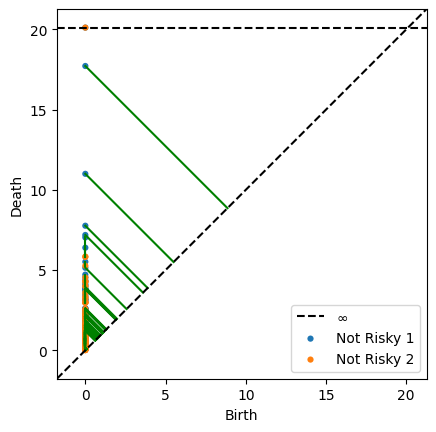

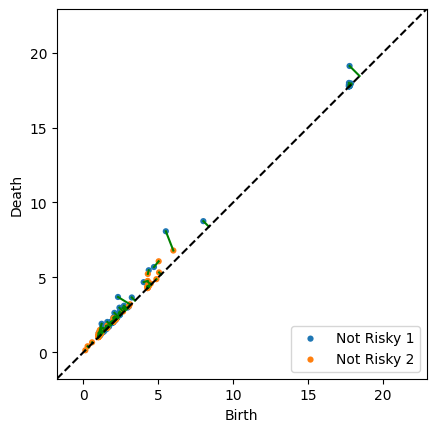

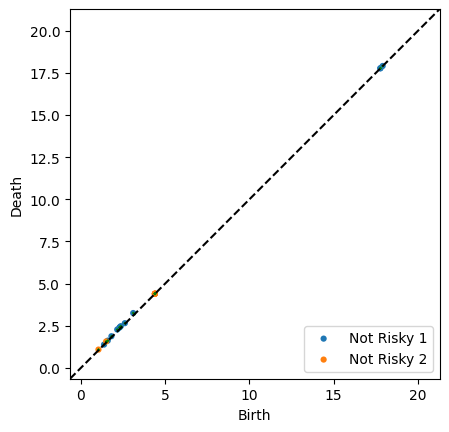

In [ ]:
for i in range(3):
    dist_bottleneck, matching = persim.wasserstein(dgm[i],dgmh2[i],matching=True)
    persim.wasserstein_matching(dgm[i],dgmh2[i],matching, labels=['Not Risky 1','Not Risky 2'])
    plt.show()

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:51: UserWarning:

dgm1 has points with non-finite death times;ignoring those points

/home/jayati/.local/lib/python3.10/site-packages/persim/wasserstein.py:61: UserWarning:

dgm2 has points with non-finite death times;ignoring those points



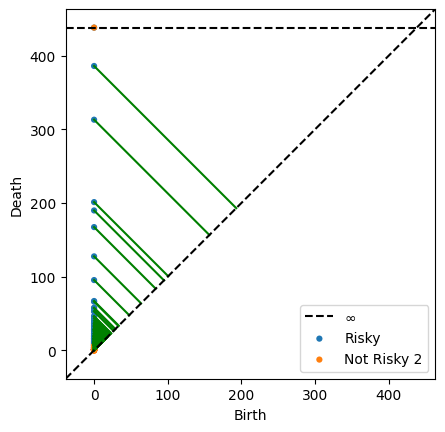

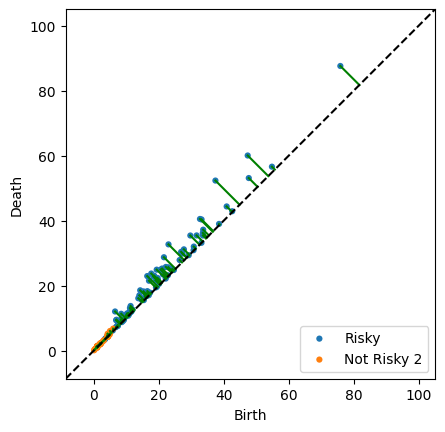

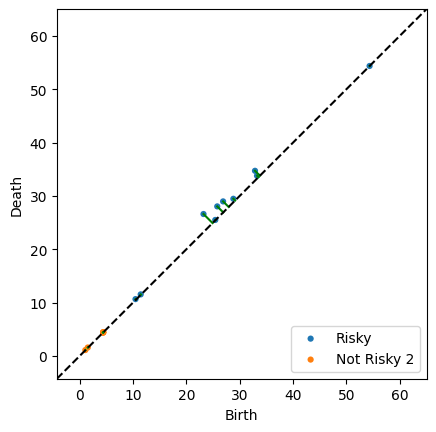

In [ ]:
for i in range(3):
    dist_bottleneck, matching = persim.wasserstein(dgmr1[i],dgmh2[i],matching=True)
    persim.wasserstein_matching(dgmr1[i],dgmh2[i],matching, labels=['Risky','Not Risky 2'])
    plt.show()

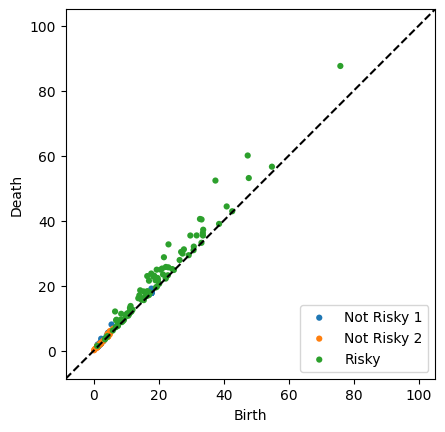

In [ ]:
dgm_h1 = ripser.ripser(dfh1)['dgms'][1]
dgm_h2 = ripser.ripser(dfh2)['dgms'][1]
dgm_r1 = ripser.ripser(dfr1)['dgms'][1]

persim.plot_diagrams([dgm_h1,dgm_h2,dgm_r1],labels=['Not Risky 1','Not Risky 2','Risky'])
plt.show()

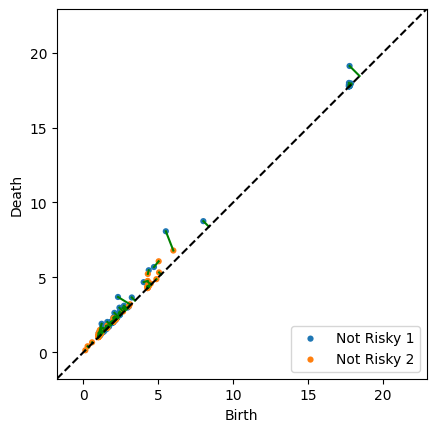

In [ ]:
dist_bottleneck, matching = persim.wasserstein(dgm_h1,dgm_h2,matching=True)
persim.wasserstein_matching(dgm_h1,dgm_h2,matching, labels=['Not Risky 1','Not Risky 2'])
plt.show()

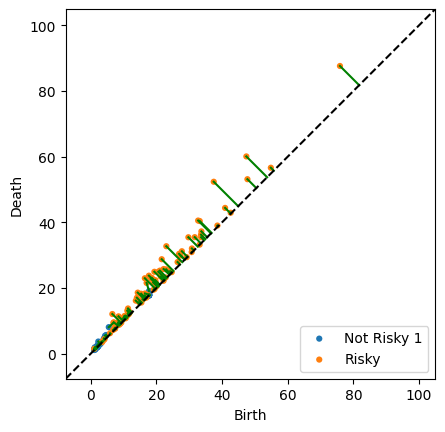

In [ ]:
dist_bottleneck, matching = persim.wasserstein(dgm_h1,dgm_r1,matching=True)
persim.wasserstein_matching(dgm_h1,dgm_r1,matching, labels=['Not Risky 1','Risky'])
plt.show()

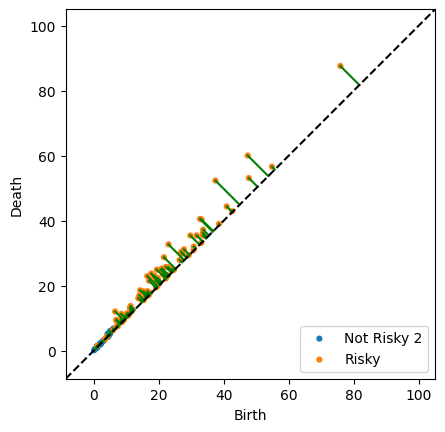

In [ ]:
dist_bottleneck, matching = persim.wasserstein(dgm_h2,dgm_r1,matching=True)
persim.wasserstein_matching(dgm_h2,dgm_r1,matching, labels=['Not Risky 2','Risky'])
plt.show()

In [ ]:
persim.sliced_wasserstein(dgm_h1,dgm_r1)

104.05412490059277

In [ ]:
persim.sliced_wasserstein(dgm_h2,dgm_r1)

103.02872087486843

In [ ]:
persim.sliced_wasserstein(dgm_h1,dgm_h2)

8.456601772078058

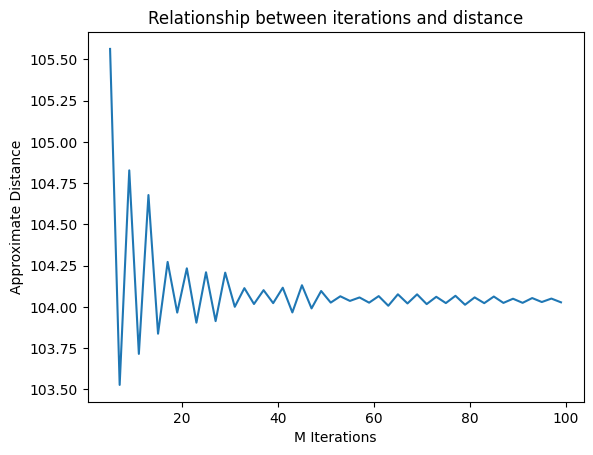

In [ ]:
Ms = range(5, 100, 2)
ds = [persim.sliced_wasserstein(dgm_r1, dgm_h1, M=M) for M in Ms]



plt.plot(Ms, ds)
plt.xlabel("M Iterations")
plt.ylabel("Approximate Distance")
plt.title("Relationship between iterations and distance")
plt.show()



In [ ]:
Ms = range(5, 100, 2)
ds = [persim.sliced_wasserstein(dgm_r1, dgm_h2, M=M) for M in Ms]



plt.plot(Ms, ds)
plt.xlabel("M Iterations")
plt.ylabel("Approximate Distance")
plt.title("Relationship between iterations and distance r1 and h1")
plt.show()

NameError: name 'dgm_r1' is not defined

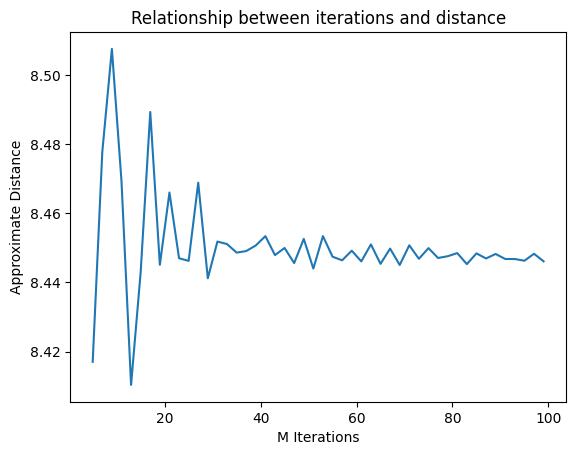

In [ ]:
Ms = range(5, 100, 2)
ds = [persim.sliced_wasserstein(dgm_h2, dgm_h1, M=M) for M in Ms]



plt.plot(Ms, ds)
plt.xlabel("M Iterations")
plt.ylabel("Approximate Distance")
plt.title("Relationship between iterations and distance")
plt.show()

In [ ]:
persim.heat(dgm_h1,dgm_h2)

1.7072878318487847

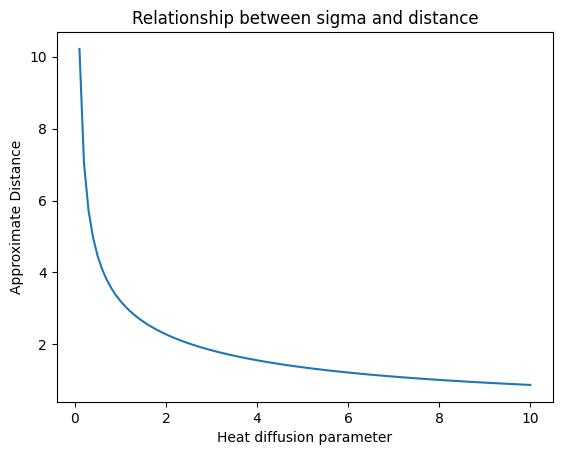

In [ ]:
sigmas = np.linspace(0.1, 10, 100)
ds = [persim.heat(dgm_h1, dgm_r1, sigma=s) for s in sigmas]
plt.plot(sigmas, ds)
plt.xlabel("Heat diffusion parameter")
plt.ylabel("Approximate Distance")
plt.title("Relationship between sigma and distance")
plt.show()

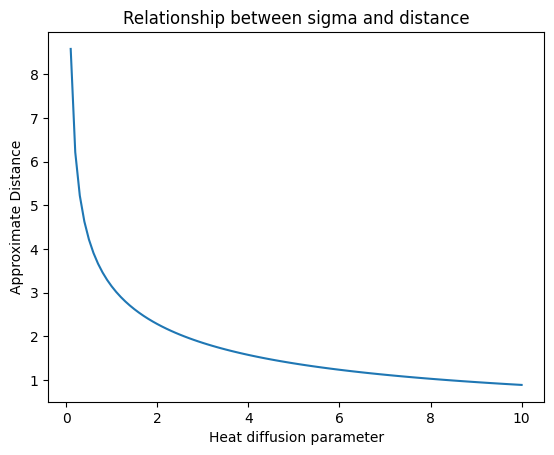

In [ ]:
sigmas = np.linspace(0.1, 10, 100)
ds = [persim.heat(dgm_h2, dgm_r1, sigma=s) for s in sigmas]
plt.plot(sigmas, ds)
plt.xlabel("Heat diffusion parameter")
plt.ylabel("Approximate Distance")
plt.title("Relationship between sigma and distance")
plt.show()

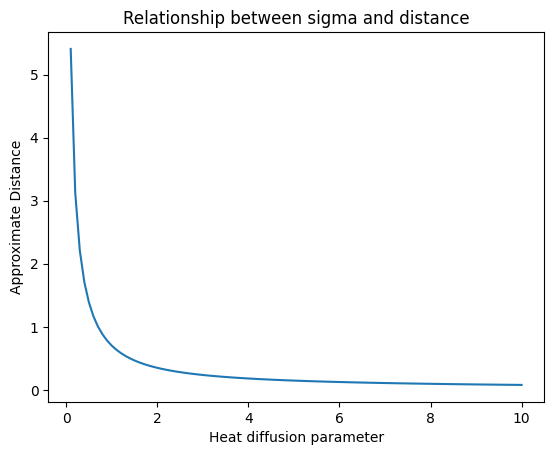

In [ ]:
sigmas = np.linspace(0.1, 10, 100)
ds = [persim.heat(dgm_h2, dgm_h1, sigma=s) for s in sigmas]
plt.plot(sigmas, ds)
plt.xlabel("Heat diffusion parameter")
plt.ylabel("Approximate Distance")
plt.title("Relationship between sigma and distance")
plt.show()

In [ ]:
b = graph.vs[5]["node_elements"]
b1 = b = graph.vs[6]["node_elements"]
a1 = set(b) 
a2 = set(b1)
a = a1 and a2
a = list(a)


dfb = df.iloc[a]
print(dfb.describe())

IndexError: vertex index out of range

In [ ]:
X1 = df1[None,:,:]

In [ ]:
import gtda

In [ ]:
from gtda.homology import VietorisRipsPersistence
homology_dimensions = (0,1,2)
VRP = VietorisRipsPersistence(homology_dimensions = homology_dimensions,n_jobs=-1)

In [ ]:
VRP.fit_transform_plot(X1)

array([[[0.        , 0.0104    , 0.        ],
        [0.        , 0.0208    , 0.        ],
        [0.        , 0.0208    , 0.        ],
        ...,
        [1.59819067, 1.62025607, 2.        ],
        [1.50399053, 1.57238758, 2.        ],
        [1.37807775, 1.38660264, 2.        ]]])

In [ ]:
from ripser import Rips
from persim import PersImage
from persim import PersistenceImager
import persim
from persim import persistent_entropy

In [ ]:
rips = Rips(maxdim=2, coeff=2)
diagrams = [rips.fit_transform(df1) ]
#diagrams_h1 = [rips.fit_transform(df)[1] ]

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


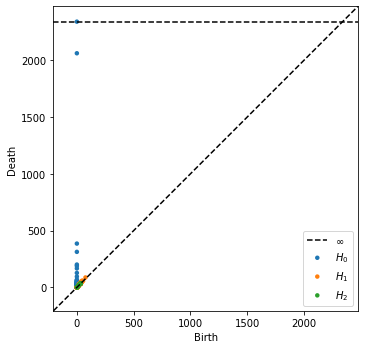

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(121)

rips.plot(diagrams[0], show=False)
#plt.subplot(122)
#rips.plot(diagrams[1], show=False)
plt.show()



In [ ]:
persistent_entropy.persistent_entropy(diagrams[0], keep_inf=False, val_inf=None, normalize=False)

array([4.57696021, 4.45874872, 2.01023527])

In [ ]:
graph = mapper.fit_transform(X)

In [ ]:
b = graph.vs[3]["node_elements"]
dfb = df.iloc[b]
dfb["Risk"].value_counts()

0    246
1     17
Name: Risk, dtype: int64

In [ ]:
graph.vs[11]['node_elements']

array([572])

In [ ]:
a = graph.vs[7]['node_elements']
dfa = df.iloc[a]
dfa["Risk"].value_counts()

0    162
1      4
Name: Risk, dtype: int64

In [ ]:
from gtda.homology import VietorisRipsPersistence

In [ ]:
test.shape

(772, 27)

In [ ]:
VR = VietorisRipsPersistence()
Xt = VR.fit_transform(test1)

In [ ]:
VR.plot(Xt)

NameError: name 'VR' is not defined

In [ ]:
VR = VietorisRipsPersistence()
VR.fit([X])
Xt = VR.transform_plot([X], sample=0);


In [ ]:
VR = VietorisRipsPersistence()
Xt = VR.fit_transform_plot([X], y)

In [ ]:
diagrams = VR.fit_transform([X])
diagrams.shape

(1, 1051, 3)

In [ ]:
test1.shape

(1, 772, 27)

IndexError: index 1 is out of bounds for axis 0 with size 1

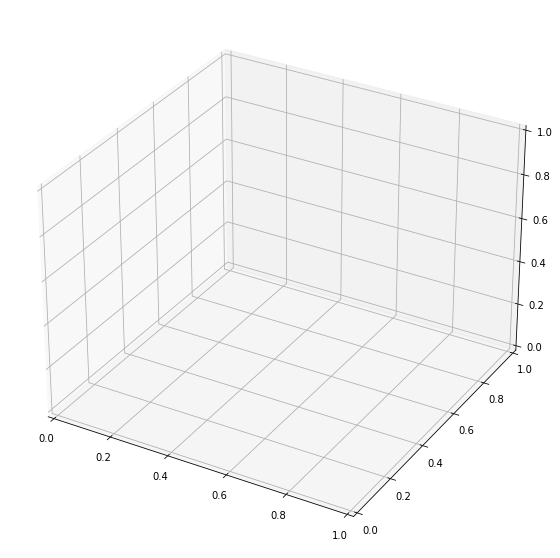

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
space = np.array(diagrams) # all possible triplets of numbers from 0 to N-1
#volume = np.random.rand(N, N, N) # generate random data
ax.scatter(space[0,:], space[1,:], space[2,:])

array([[0.        , 0.        , 0.        , ..., 1.00041628, 1.00041628,
        1.00011635]])

In [ ]:
from gtda.plotting import plot_diagram

i = 0
plot_diagram(diagrams[i])


In [ ]:
from gtda.diagrams import PersistenceEntropy

PE = PersistenceEntropy()
features = PE.fit_transform(diagrams)
features

array([[6.60104136, 6.43735802]])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(features,y )
model = RandomForestClassifier()
model.fit(X_train, y_train)
model.score(X_valid, y_valid)


ValueError: With n_samples=1, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
x = np.array([X])

In [ ]:
from gtda.plotting import plot_point_cloud
i = 0
plot_point_cloud(x[i])

In [ ]:
X = np.array(X)
X.shape
xo = np.array([X[0]])
xo = np.reshape(xo,(1,-1))
xo.shape

(1, 26)

In [ ]:
from gtda.point_clouds import ConsistentRescaling

cr = ConsistentRescaling()

X_rescaled = cr.fit_transform(xo)

print(X_rescaled.shape)


ValueError: Expected 2D array, got 1D array instead:
array=[ 3.89   23.      4.18    0.6     2.508   2.5     0.2     0.5     6.68
  5.      0.2     1.      3.38    0.2     0.676   2.      0.2     0.4
  0.      0.2     0.      2.4     8.574   0.4     0.5     1.7148].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
a = [1,2,3,4]
b = [3,4,5,6,7]
c = [8,1,4,0,7,2]
z = set(c)
x = set(a) 
y = set(b)
x and y and c

[8, 1, 4, 0, 7, 2]

In [ ]:
x.union(y,z) 

{0, 1, 2, 3, 4, 5, 6, 7, 8}